In [0]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from keras.models import model_from_json
print(tf.__version__)

1.13.1


Using TensorFlow backend.


In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"blmcmcn","key":"48e92572aaafaf03560fd679ac225c83"}'}

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:

!kaggle competitions download -c facial-keypoints-detection -p /content

 68% 41.0M/60.1M [00:00<00:00, 36.1MB/s]
100% 60.1M/60.1M [00:00<00:00, 102MB/s] 
 56% 9.00M/16.0M [00:00<00:00, 30.5MB/s]
100% 16.0M/16.0M [00:00<00:00, 40.4MB/s]
  0% 0.00/201k [00:00<?, ?B/s]
100% 201k/201k [00:00<00:00, 210MB/s]
  0% 0.00/843k [00:00<?, ?B/s]
100% 843k/843k [00:00<00:00, 116MB/s]


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!unzip \*.zip

Archive:  test.zip
  inflating: test.csv                

Archive:  training.zip
  inflating: training.csv            

2 archives were successfully processed.


In [0]:
TRAIN = 'training.csv'
TEST = 'test.csv'
IdLookup = 'IdLookupTable.csv'


In [0]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "0"
set_session(tf.Session(config=config))


In [0]:
def plot_sample(X,y,axs):
    
    axs.imshow(X.reshape(96,96),cmap="gray")
    axs.scatter(48*y[0::2]+ 48,48*y[1::2]+ 48)
    
def load(test=False, cols=None):

    fname = TEST if test else TRAIN
    df = read_csv(os.path.expanduser(fname)) 

    
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  
        df = df[list(cols) + ['Image']]

    myprint = df.count()
    myprint = myprint.reset_index()
    print(myprint)  
    df = df.dropna()  
    
    X = np.vstack(df['Image'].values) / 255.  
    X = X.astype(np.float32)

    if not test:  
      
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  
        X, y = shuffle(X, y, random_state=42)  
        y = y.astype(np.float32)
    else:
        y = None
        
    return X, y


def load2d(test=False,cols=None):

    re = load(test, cols)
    
    X = re[0].reshape(-1,96,96,1)
    #X = np.repeat(Xprep, 3, -1) ##uncomment when using InceptionV3
    y = re[1]

    return X, y

  
def plot_loss(hist,name,plt,RMSE_TF=False):
    
    loss = hist['loss']
    val_loss = hist['val_loss']
    if RMSE_TF:
        loss = np.sqrt(np.array(loss))*48 
        val_loss = np.sqrt(np.array(val_loss))*48 
        
    plt.plot(loss,"--",linewidth=3,label="train:"+name)
    plt.plot(val_loss,linewidth=3,label="val:"+name)
 

from keras import backend as K

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

    
def plot_R2(hist,name,plt):
    
    R2 = hist['coeff_determination']
    val_R2 = hist['val_coeff_determination']
        
    plt.plot(R2,"--",linewidth=3,label="train:"+name)
    plt.plot(val_R2,linewidth=3,label="val:"+name)

In [0]:
X, y = load()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
    X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
    y.shape, y.min(), y.max()))

                        index     0
0           left_eye_center_x  7039
1           left_eye_center_y  7039
2          right_eye_center_x  7036
3          right_eye_center_y  7036
4     left_eye_inner_corner_x  2271
5     left_eye_inner_corner_y  2271
6     left_eye_outer_corner_x  2267
7     left_eye_outer_corner_y  2267
8    right_eye_inner_corner_x  2268
9    right_eye_inner_corner_y  2268
10   right_eye_outer_corner_x  2268
11   right_eye_outer_corner_y  2268
12   left_eyebrow_inner_end_x  2270
13   left_eyebrow_inner_end_y  2270
14   left_eyebrow_outer_end_x  2225
15   left_eyebrow_outer_end_y  2225
16  right_eyebrow_inner_end_x  2270
17  right_eyebrow_inner_end_y  2270
18  right_eyebrow_outer_end_x  2236
19  right_eyebrow_outer_end_y  2236
20                 nose_tip_x  7049
21                 nose_tip_y  7049
22        mouth_left_corner_x  2269
23        mouth_left_corner_y  2269
24       mouth_right_corner_x  2270
25       mouth_right_corner_y  2270
26     mouth_center_top_lip_

In [0]:
%%time
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(100,input_dim = X.shape[1]))
model.add(Activation('relu'))
model.add(Dense(30))


sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd,metrics=[coeff_determination])
hist = model.fit(X, y, epochs=600, validation_split=0.2,verbose=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 1712 samples, validate on 428 samples
Epoch 1/600
1712/1712 [==============================] - 1s 601us/step - loss: 0.0653 - coeff_determination: 0.5723 - val_loss: 0.0111 - val_coeff_determination: 0.9293
Epoch 2/600
1712/1712 [==============================] - 0s 103us/step - loss: 0.0109 - coeff_determination: 0.9287 - val_loss: 0.0097 - val_coeff_determination: 0.9376
Epoch 3/600
1712/1712 [==============================] - 0s 104us/step - loss: 0.0093 - coeff_determination: 0.9393 - val_loss: 0.0090 - val_coeff_determination: 0.9423
Epoch 4/600
1712/1712 [==============================] - 0s 104us/step - loss: 0.0086 - coeff_determination: 0.9439 - val_loss: 0.0083 - val_coeff_determination: 0.9469
Epoch 5/600
1712/1712 [==============================] - 0s 112us/step - loss: 0.0081 - coeff_determination: 0.9474 - val_loss: 0.0079 - val_coeff_determinat

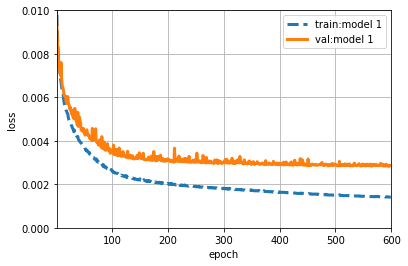

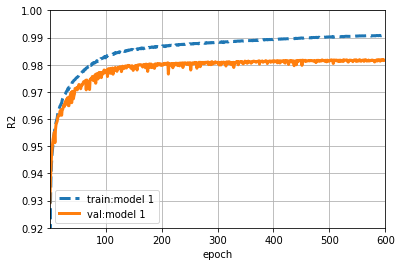

In [0]:
plot_loss(hist.history,"model 1",plt)
plt.legend()
plt.grid()
plt.axis([1, 600, 0, .01])
plt.yscale("linear")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()


plot_R2(hist.history,"model 1",plt)
plt.legend()
plt.grid()
plt.axis([1, 600, 0.92, 1])
plt.yscale("linear")
plt.xlabel("epoch")
plt.ylabel("R2")
plt.show()

In [0]:
X_test , _ = load(test=True)
y_test = model.predict(X_test)

     index     0
0  ImageId  1783
1    Image  1783


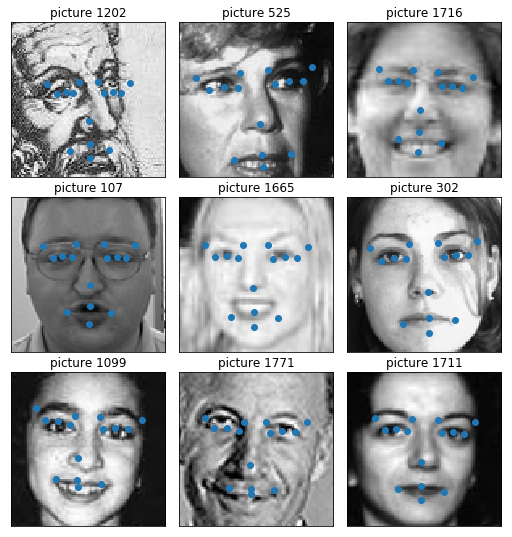

In [0]:
fig = plt.figure(figsize=(7, 7))
fig.subplots_adjust(hspace=0.13,wspace=0.0001,
                    left=0,right=1,bottom=0, top=1)
Npicture = 9
count = 1
for irow in range(Npicture):
    ipic = np.random.choice(X_test.shape[0])
    ax = fig.add_subplot(Npicture/3 , 3, count,xticks=[],yticks=[])        
    plot_sample(X_test[ipic],y_test[ipic],ax)
    ax.set_title("picture "+ str(ipic))
    count += 1
plt.show()

In [0]:
from keras.models import model_from_json

def save_model(model,name):
    
    json_string = model.to_json()
    open(name + '_architecture.json', 'w').write(json_string)
    model.save_weights(name+'_weights.h5')
    
def load_model(name):
    model = model_from_json(open(name + '_architecture.json').read())
    model.load_weights(name + '_weights.h5')
    return(model)

save_model(model,"model1")
model = load_model("model1")

In [0]:
del X, y, X_test, y_test

In [0]:
# load data
X, y = load2d()
X.shape

                        index     0
0           left_eye_center_x  7039
1           left_eye_center_y  7039
2          right_eye_center_x  7036
3          right_eye_center_y  7036
4     left_eye_inner_corner_x  2271
5     left_eye_inner_corner_y  2271
6     left_eye_outer_corner_x  2267
7     left_eye_outer_corner_y  2267
8    right_eye_inner_corner_x  2268
9    right_eye_inner_corner_y  2268
10   right_eye_outer_corner_x  2268
11   right_eye_outer_corner_y  2268
12   left_eyebrow_inner_end_x  2270
13   left_eyebrow_inner_end_y  2270
14   left_eyebrow_outer_end_x  2225
15   left_eyebrow_outer_end_y  2225
16  right_eyebrow_inner_end_x  2270
17  right_eyebrow_inner_end_y  2270
18  right_eyebrow_outer_end_x  2236
19  right_eyebrow_outer_end_y  2236
20                 nose_tip_x  7049
21                 nose_tip_y  7049
22        mouth_left_corner_x  2269
23        mouth_left_corner_y  2269
24       mouth_right_corner_x  2270
25       mouth_right_corner_y  2270
26     mouth_center_top_lip_

(2140, 96, 96, 1)

In [0]:
from keras.layers import Conv2D, MaxPooling2D,Flatten, Dropout
from keras.applications import InceptionV3
from keras.engine import  Model
from keras.layers import Input



def SimpleCNN(withDropout=False):
    
    
    model = Sequential()
    
#     conv_base = InceptionV3(weights = 'imagenet', include_top=False, input_shape=(96, 96, 3)) #
#     conv_base.trainable = False
    
    model.add(Conv2D(32,(3, 3), input_shape = (96, 96, 1)))
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size = (2,2)))
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Conv2D(64,(2,2)))
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size = (2,2)))
    if withDropout:
        model.add(Dropout(0.1))
    
    model.add(Conv2D(128,(2,2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Flatten())
    
    model.add(Dense(500))
    model.add(Activation('relu'))
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Dense(500))
    model.add(Activation('relu'))
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Dense(30))
    sgd = SGD(lr=0.01,momentum = 0.9,nesterov=True)
    model.compile(loss="mean_squared_error",optimizer=sgd,metrics=[coeff_determination])
    return(model)

In [0]:
%%time
model2 = SimpleCNN()

hist2 = model2.fit(X,y,epochs=600,validation_split=0.2,verbose=True)

Train on 1712 samples, validate on 428 samples
Epoch 1/600
1712/1712 [==============================] - 2s 1ms/step - loss: 0.0402 - coeff_determination: 0.7393 - val_loss: 0.0067 - val_coeff_determination: 0.9572
Epoch 2/600
1712/1712 [==============================] - 1s 435us/step - loss: 0.0065 - coeff_determination: 0.9574 - val_loss: 0.0059 - val_coeff_determination: 0.9625
Epoch 3/600
1712/1712 [==============================] - 1s 429us/step - loss: 0.0059 - coeff_determination: 0.9618 - val_loss: 0.0054 - val_coeff_determination: 0.9654
Epoch 4/600
1712/1712 [==============================] - 1s 433us/step - loss: 0.0055 - coeff_determination: 0.9644 - val_loss: 0.0051 - val_coeff_determination: 0.9673
Epoch 5/600
1712/1712 [==============================] - 1s 433us/step - loss: 0.0052 - coeff_determination: 0.9663 - val_loss: 0.0049 - val_coeff_determination: 0.9685
Epoch 6/600
1712/1712 [==============================] - 1s 430us/step - loss: 0.0050 - coeff_determination: 0

In [0]:

plot_loss(hist.history,"model 1",plt)
plot_loss(hist2.history,"model 2",plt)
plt.legend()
plt.grid()
plt.axis([1, 600, 0, .007])
plt.yscale("linear")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()


plot_R2(hist.history,"model 1",plt)
plot_R2(hist2.history,"model 2",plt)
plt.legend()
plt.grid()
plt.axis([1, 600, 0.93, 1])
plt.yscale("linear")
plt.xlabel("epoch")
plt.ylabel("R2")
plt.show()

In [0]:
sample1,_ = load(test=True)
sample2,_ = load2d(test=True)
y_pred1 = model.predict(sample1)
y_pred2 = model2.predict(sample2)

     index     0
0  ImageId  1783
1    Image  1783
     index     0
0  ImageId  1783
1    Image  1783


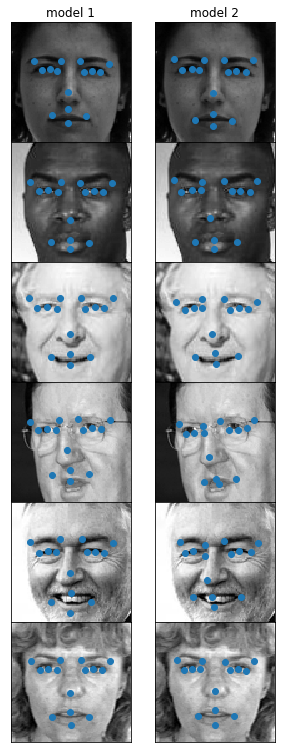

In [0]:
fig = plt.figure(figsize=(4, 10))
fig.subplots_adjust(hspace=0.001,wspace=0.001,
                    left=0,right=1,bottom=0, top=1)
Npicture = 6
count = 1

for irow in range(Npicture):
    ipic = np.random.choice(sample2.shape[0])
    ax = fig.add_subplot(Npicture, 2, count,xticks=[],yticks=[])        
    plot_sample(sample1[ipic],y_pred1[ipic],ax)
    if count < 3:
        ax.set_title("model 1")
        
    count += 1
    ax = fig.add_subplot(Npicture, 2, count,xticks=[],yticks=[])  
    plot_sample(sample2[ipic],y_pred2[ipic],ax)
    if count < 3:
        ax.set_title("model 2")
    count += 1
plt.show()

In [0]:
class DataModifier(object):
    def fit(self,X_,y_):
        return(NotImplementedError)
    
class FlipPic(DataModifier):
    def __init__(self,flip_indices=None):
        if flip_indices is None:
            flip_indices = [
                (0, 2), (1, 3),
                (4, 8), (5, 9), (6, 10), (7, 11),
                (12, 16), (13, 17), (14, 18), (15, 19),
                (22, 24), (23, 25)
                ]
        
        self.flip_indices = flip_indices
        
    def fit(self,X_batch,y_batch):

        batch_size = X_batch.shape[0]
        indices = np.random.choice(batch_size, batch_size//2, replace=False)

        X_batch[indices] = X_batch[indices, :, ::-1,:]
        y_batch[indices, ::2] = y_batch[indices, ::2] * -1

        for a, b in self.flip_indices:
            y_batch[indices, a], y_batch[indices, b] = (
                    y_batch[indices, b], y_batch[indices, a]
                )
        return X_batch, y_batch

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)


(1712, 96, 96, 1)


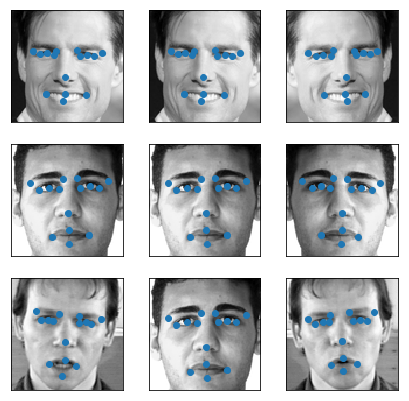

In [0]:
from keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator()
modifier = FlipPic()

fig = plt.figure(figsize=(7,7))

count = 1
for batch in generator.flow(X_train[:5],y_train[:5]):
    X_batch, y_batch = modifier.fit(*batch)

    ax = fig.add_subplot(3,3, count,xticks=[],yticks=[])  
    plot_sample(X_batch[0],y_batch[0],ax)
    count += 1
    if count == 10:
        break
plt.show()

In [0]:
def fit(model,modifier,train,validation,
        batch_size=32,epochs=1000,print_every=10,patience=np.Inf):
      
    X_train,y_train = train
    X_val, y_val    = validation
    
    generator = ImageDataGenerator()
    
    history = {"loss":[],"val_loss":[], "coeff_determination":[],"val_coeff_determination":[]}
    for e in range(epochs):
        if e % print_every == 0:
            print('Epoch {:4}:'.format(e)), 
        
        batches = 0
        loss_epoch = []
        
        for X_batch, y_batch in generator.flow(X_train, y_train, batch_size=batch_size):
            X_batch, y_batch = modifier.fit(X_batch, y_batch)
            hist = model.fit(X_batch, y_batch,verbose=False,epochs=1)
            loss_epoch.extend(hist.history["loss"])
            batches += 1
            if batches >= len(X_train) / batch_size:
                
                break   
        
        loss = np.mean(loss_epoch)
        
        y_pred = model.predict(X)
        #R2 = 1 - np.mean((y - y_pred)**2)/np.mean((y - np.mean(y))**2)
        
        history["loss"].append(loss)
        #history["coeff_determination"].append(R2)
        
        y_pred_val = model.predict(X_val)
        val_loss = np.mean((y_pred_val - y_val)**2)
        #val_R2 = 1 - np.mean((y_val - y_pred_val)**2)/np.mean((y_val - np.mean(y_val))**2)
        history["val_loss"].append(val_loss)
        #history["val_coeff_determination"].append(val_R2)
        if e % print_every == 0:
            print("loss - {:6.5f}, val_loss - {:6.5f}".format(loss,val_loss))
        min_val_loss = np.min(history["val_loss"])
        
        if patience is not np.Inf:
            if np.all(min_val_loss < np.array(history["val_loss"])[-patience:]):
                break
    return(history)

In [0]:
%%time
#X, y = load2d()
model3 = SimpleCNN()
hist3 = fit(model3,modifier,
           train=(X_train,y_train),
           validation=(X_val,y_val),
           batch_size=32,epochs=1000,print_every=100
           )

Epoch    0:
loss - 0.03999, val_loss - 0.00656
Epoch  100:
loss - 0.00296, val_loss - 0.00281
Epoch  200:
loss - 0.00172, val_loss - 0.00172
Epoch  300:
loss - 0.00138, val_loss - 0.00146
Epoch  400:
loss - 0.00117, val_loss - 0.00132
Epoch  500:
loss - 0.00103, val_loss - 0.00124
Epoch  600:
loss - 0.00093, val_loss - 0.00121
Epoch  700:
loss - 0.00084, val_loss - 0.00117
Epoch  800:
loss - 0.00077, val_loss - 0.00111
Epoch  900:
loss - 0.00070, val_loss - 0.00109
CPU times: user 12min 35s, sys: 3min 25s, total: 16min
Wall time: 17min 2s


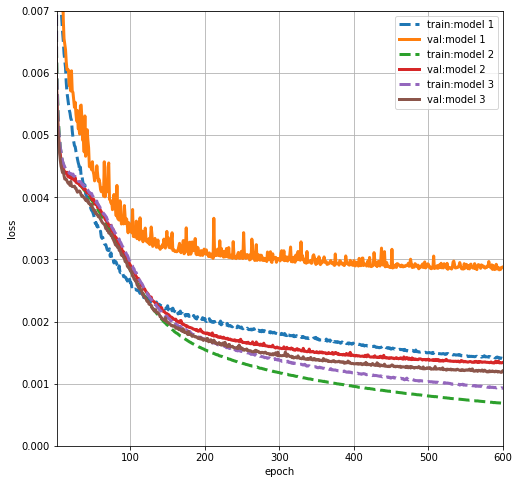

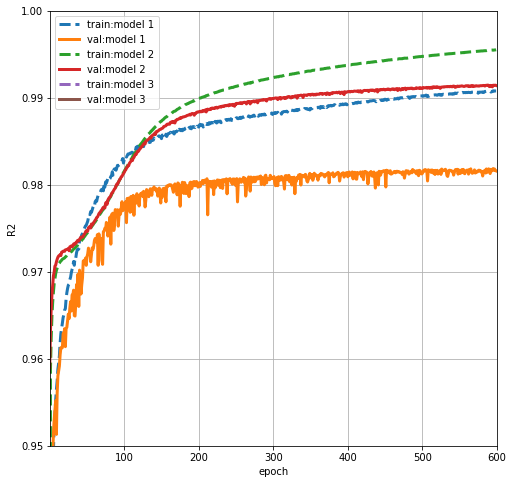

In [0]:
plt.figure(figsize=(8,8))
plot_loss(hist.history,"model 1",plt)
plot_loss(hist2.history,"model 2",plt)
plot_loss(hist3,"model 3",plt)
plt.legend()
plt.grid()
plt.axis([1, 600, 0, 0.007])
plt.yscale("linear")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()


plt.figure(figsize=(8,8))
plot_R2(hist.history,"model 1",plt)
plot_R2(hist2.history,"model 2",plt)
plot_R2(hist3,"model 3",plt)
plt.legend()
plt.grid()
plt.axis([1, 600, 0.95, 1])
plt.yscale("linear")
plt.xlabel("epoch")
plt.ylabel("R2")
plt.show()


In [0]:
class ShiftFlipPic(FlipPic):
    def __init__(self,flip_indices=None,prop=0.1):
        super(ShiftFlipPic,self).__init__(flip_indices)
        self.prop = prop
        
    def fit(self,X,y):
        X, y = super(ShiftFlipPic,self).fit(X,y)
        X, y = self.shift_image(X,y,prop=self.prop)
        return(X,y)
    def random_shift(self,shift_range,n=96):
        
        shift = np.random.randint(-shift_range,
                                  shift_range)
        def shift_left(n,shift):
            shift = np.abs(shift)
            return(0,n - shift)
        def shift_right(n,shift):
            shift = np.abs(shift)
            return(shift,n)

        if shift < 0:
            keep = shift_left(n,shift) 
            assign = shift_right(n,shift)
        else:
            assign = shift_left(n,shift) ## less than 96
            keep = shift_right(n,shift)

        return((keep,  assign, shift))

    def shift_single_image(self,x_,y_,prop=0.1):
        
        w_shift_max = int(x_.shape[0] * prop)
        h_shift_max = int(x_.shape[1] * prop)

        w_keep,w_assign,w_shift = self.random_shift(w_shift_max)
        h_keep,h_assign,h_shift = self.random_shift(h_shift_max)

        x_[w_assign[0]:w_assign[1],
           h_assign[0]:h_assign[1],:] = x_[w_keep[0]:w_keep[1],
                                           h_keep[0]:h_keep[1],:]

        y_[0::2] = y_[0::2] - h_shift/float(x_.shape[0]/2.)
        y_[1::2] = y_[1::2] - w_shift/float(x_.shape[1]/2.)
        return(x_,y_)

    def shift_image(self,X,y,prop=0.1):
            
            for irow in range(X.shape[0]):
                x_ = X[irow]
                y_ = y[irow]
                X[irow],y[irow] = self.shift_single_image(x_,y_,prop=prop)
            return(X,y)


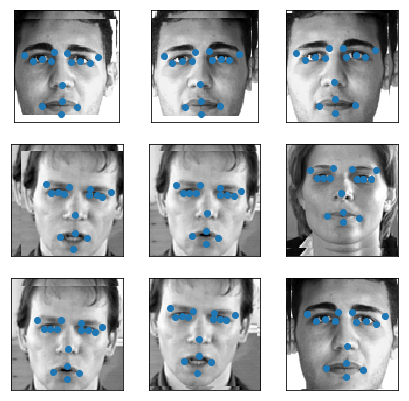

In [0]:
from keras.preprocessing.image import ImageDataGenerator
generator = ImageDataGenerator()
shiftFlipPic = ShiftFlipPic(prop=0.1)

fig = plt.figure(figsize=(7,7))

count = 1
for batch in generator.flow(X_train[:5],y_train[:5]):
    X_batch, y_batch = shiftFlipPic.fit(*batch)

    ax = fig.add_subplot(3,3, count,xticks=[],yticks=[])  
    plot_sample(X_batch[0],y_batch[0],ax)
    count += 1
    if count == 10:
        break
plt.show()

In [0]:
%%time
model4 = SimpleCNN()
hist4 = fit(model4,shiftFlipPic,
           train=(X_train,y_train),
           validation=(X_val,y_val),
           batch_size=32,epochs=1000,print_every=50,patience=100)


Epoch    0:
loss - 0.03965, val_loss - 0.00743
Epoch   50:
loss - 0.00421, val_loss - 0.00280
Epoch  100:
loss - 0.00329, val_loss - 0.00209
Epoch  150:
loss - 0.00275, val_loss - 0.00182
Epoch  200:
loss - 0.00253, val_loss - 0.00172
Epoch  250:
loss - 0.00239, val_loss - 0.00167
Epoch  300:
loss - 0.00210, val_loss - 0.00154
Epoch  350:
loss - 0.00199, val_loss - 0.00148
Epoch  400:
loss - 0.00198, val_loss - 0.00148
Epoch  450:
loss - 0.00180, val_loss - 0.00139
Epoch  500:
loss - 0.00175, val_loss - 0.00135
Epoch  550:
loss - 0.00170, val_loss - 0.00135
Epoch  600:
loss - 0.00163, val_loss - 0.00129
Epoch  650:
loss - 0.00154, val_loss - 0.00129
Epoch  700:
loss - 0.00151, val_loss - 0.00126
Epoch  750:
loss - 0.00149, val_loss - 0.00124
Epoch  800:
loss - 0.00142, val_loss - 0.00121
Epoch  850:
loss - 0.00144, val_loss - 0.00120
Epoch  900:
loss - 0.00137, val_loss - 0.00120
Epoch  950:
loss - 0.00139, val_loss - 0.00117
CPU times: user 13min 32s, sys: 3min 27s, total: 16min 59s
W

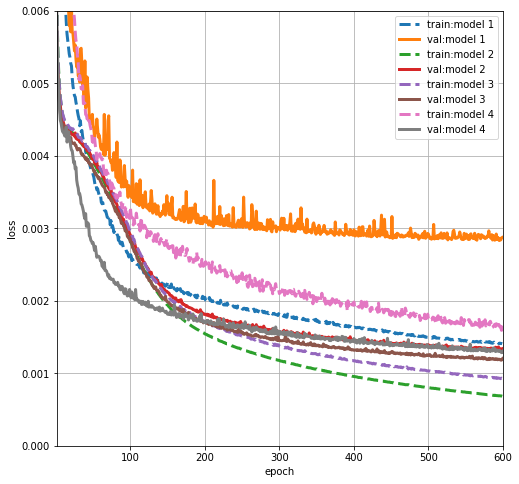

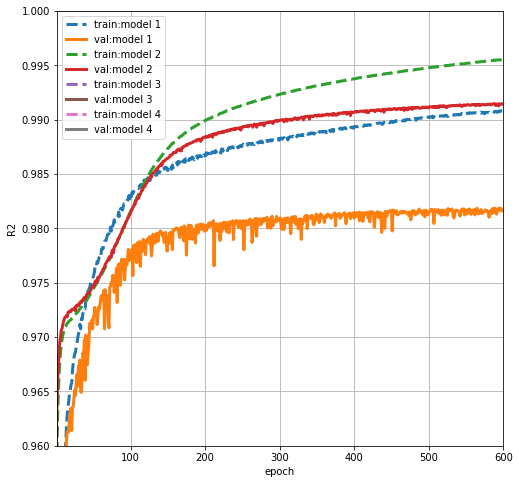

In [0]:

plt.figure(figsize=(8,8))
plot_loss(hist.history,"model 1",plt)
plot_loss(hist2.history,"model 2",plt)
plot_loss(hist3,"model 3",plt)
plot_loss(hist4,"model 4",plt)
plt.legend()
plt.grid()
plt.axis([1, 600, 0, 0.006])
plt.yscale("linear")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()


plt.figure(figsize=(8,8))
plot_R2(hist.history,"model 1",plt)
plot_R2(hist2.history,"model 2",plt)
plot_R2(hist3,"model 3",plt)
plot_R2(hist4,"model 4",plt)
plt.legend()
plt.grid()
plt.axis([1, 600, 0.96, 1])
plt.yscale("linear")
plt.xlabel("epoch")
plt.ylabel("R2")
plt.show()


In [0]:
save_model(model4,"model4")

In [0]:
SPECIALIST_SETTINGS = [
    dict(
        columns=(
            'left_eye_center_x', 'left_eye_center_y',
            'right_eye_center_x', 'right_eye_center_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'nose_tip_x', 'nose_tip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'mouth_left_corner_x', 'mouth_left_corner_y',
            'mouth_right_corner_x', 'mouth_right_corner_y',
            'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'mouth_center_bottom_lip_x',
            'mouth_center_bottom_lip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'left_eye_inner_corner_x', 'left_eye_inner_corner_y',
            'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
            'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
            'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),

    dict(
        columns=(
            'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
            'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
            'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
            'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),
    ]

from collections import OrderedDict

def fit_specialists(freeze=True,
                    print_every=50,
                    epochs=3000,
                    prop=0.1,
                    name_transfer_model="model4"):
    specialists = OrderedDict()
 

    for setting in SPECIALIST_SETTINGS:
        
        cols = setting['columns']
        flip_indices = setting['flip_indices']
        
        X, y = load2d(cols=cols)
        X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                          test_size=0.2, 
                                                          random_state=42)
        model = load_model(name_transfer_model) 
        if freeze:
            for layer in model.layers:
                layer.trainable = False
            
        model.layers.pop() 
        model.outputs = [model.layers[-1].output]
        model.layers[-1].outbound_nodes = []
        model.add(Dense(len(cols))) 

        model.compile(loss='mean_squared_error', optimizer="adam",metrics=[coeff_determination])
        
        shiftFlipPic = ShiftFlipPic(flip_indices=flip_indices,
                                    prop=prop)
        
        
        hist = fit(model,shiftFlipPic,
                    train=(X_train,y_train),
                    validation=(X_val,y_val),
                    batch_size=32,epochs=epochs,
                    print_every=print_every) 
        
       
        specialists[cols] = {"model":model,
                             "hist":hist}
    return(specialists)

In [0]:
%%time
specialists1 = fit_specialists(freeze=True,
                    print_every=50,
                    epochs=400,
                    name_transfer_model="model4")

KeyboardInterrupt: ignored

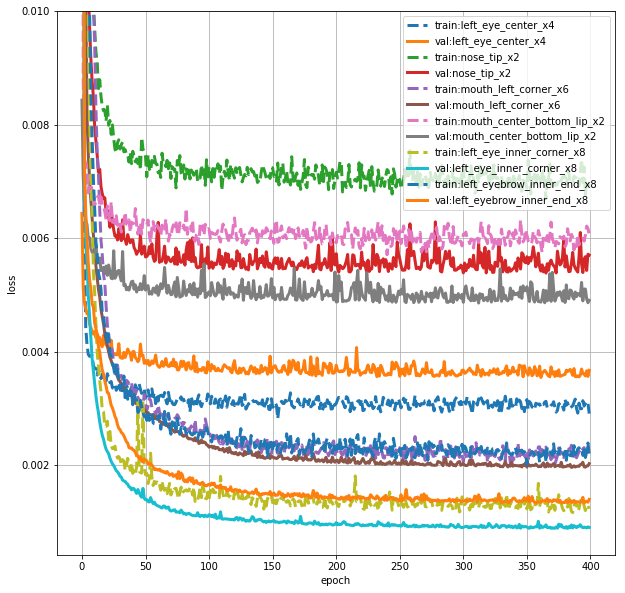

In [0]:
def plot_special_loss(specialists1,plt):
    
    i = 1
    for key , value in specialists1.items():
        plot_loss(value["hist"],key[0] + str(len(key)),plt)
        i += 1

    plt.legend()
    plt.grid()
    plt.set_yscale("linear")
    plt.set_xlabel("epoch")
    plt.set_ylabel("loss")
    
    
def plot_special_R2(specialists1,plt):
    
    i = 1
    for key , value in specialists1.items():
        plot_R2(value["hist"],key[0] + str(len(key)),plt)
        i += 1

    plt.legend()
    plt.grid()
    plt.set_yscale("linear")
    plt.set_xlabel("epoch")
    plt.set_ylabel("R2")
  
fig = plt.figure(figsize=(10,10))  
ax = fig.add_subplot(1,1,1)
ax.set_ylim(7**(-4),10**(-2))
plot_special_loss(specialists1,ax)
plt.show()


# fig = plt.figure(figsize=(10,10))  
# ax = fig.add_subplot(1,1,1)
# ax.set_ylim(7**(-4),10**(-2))
# plot_special_R2(specialists1,ax)
# plt.show()


In [0]:
from pandas import DataFrame, concat

X_test,_ = load2d(test=True)


y_pred4 = model4.predict(X_test)
landmark_nm = read_csv(os.path.expanduser(TRAIN)).columns[:-1].values
df_y_pred4 = DataFrame(y_pred4,columns = landmark_nm)


def predict_specialist(specialists1,X_test):
    y_pred_s = []
    for columns, value in specialists1.items():
        smodel = value["model"]

        y_pred = smodel.predict(X_test)
        y_pred = DataFrame(y_pred,columns=columns)
        y_pred_s.append(y_pred)

    df_y_pred_s = concat(y_pred_s,axis=1)
    return(df_y_pred_s)
df_y_pred_s = predict_specialist(specialists1,X_test)
y_pred_s = df_y_pred_s.values

     index     0
0  ImageId  1783
1    Image  1783


In [0]:

NIdLookup = read_csv(os.path.expanduser(IdLookup))

def prepare_submission(y_pred4,filename):
   
    ImageId = NIdLookup["ImageId"]
    FeatureName = NIdLookup["FeatureName"]
    RowId = NIdLookup["RowId"]
    
    submit = []
    for rowId,irow,landmark in zip(RowId,ImageId,FeatureName):
        submit.append([rowId,y_pred4[landmark].iloc[irow-1]])
    
    submit = DataFrame(submit,columns=["RowId","Location"])
    
    submit["Location"] = submit["Location"]*48 + 48
    print(submit.shape)
    loc = filename + ".csv"
    submit.to_csv(loc,index=False)
    print("File is saved at:" +  loc)
    
prepare_submission(df_y_pred4,"model4")
prepare_submission(df_y_pred_s,"special")



(27124, 2)
File is saved at:model4.csv
(27124, 2)
File is saved at:special.csv


In [0]:

df_y_pred_s = df_y_pred_s[df_y_pred4.columns]
df_compare = {}
df_compare["difference"] = ((df_y_pred_s - df_y_pred4)**2).mean(axis=1)
df_compare["RowId"] = range(df_y_pred_s.shape[0])
df_compare = DataFrame(df_compare)
df_compare = df_compare.sort_values("difference",ascending=False)

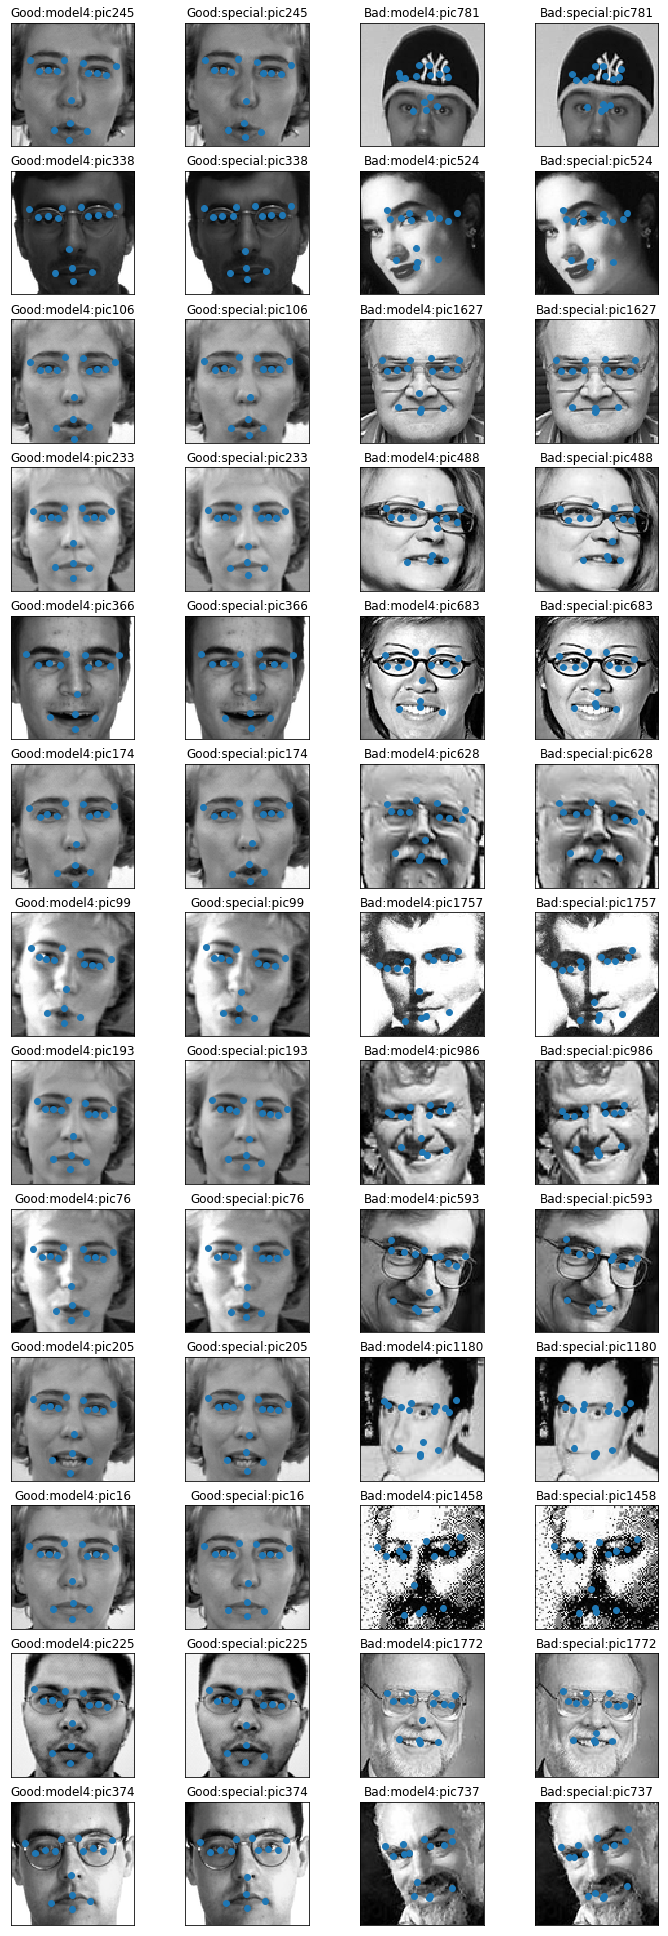

In [0]:
fig = plt.figure(figsize=(12,35))

Nsample = 13
pic_index = df_compare["RowId"].iloc[:Nsample].values
pic_index_good = df_compare["RowId"].iloc[-Nsample:].values
count = 1


for ipic_g,ipic in zip(pic_index_good,pic_index):
    
    ax = fig.add_subplot(Nsample,4,count,xticks=[],yticks=[])
    count += 1
    plot_sample(X_test[ipic_g],y_pred4[ipic_g],ax)
    ax.set_title("Good:model4:pic"+str(ipic_g))
    
    
    ax = fig.add_subplot(Nsample,4,count,xticks=[],yticks=[])
    count += 1
    plot_sample(X_test[ipic_g],y_pred_s[ipic_g],ax)
    ax.set_title("Good:special:pic"+str(ipic_g))
    

    ax = fig.add_subplot(Nsample,4,count,xticks=[],yticks=[])
    count += 1
    plot_sample(X_test[ipic],y_pred4[ipic],ax)
    ax.set_title("Bad:model4:pic"+str(ipic))
    
    
    ax = fig.add_subplot(Nsample,4,count,xticks=[],yticks=[])
    count += 1
    plot_sample(X_test[ipic],y_pred_s[ipic],ax)
    ax.set_title("Bad:special:pic"+str(ipic))

plt.show()

In [0]:
%%time
specialists2 = fit_specialists(freeze=False,
                    print_every=50,
                    epochs=400,
                    prop=0.2,
                    name_transfer_model="model4")


                index     0
0   left_eye_center_x  7039
1   left_eye_center_y  7039
2  right_eye_center_x  7036
3  right_eye_center_y  7036
4               Image  7049
Epoch    0:
loss - 0.16384, val_loss - 0.00625
Epoch   50:
loss - 0.00224, val_loss - 0.00347
Epoch  100:
loss - 0.00169, val_loss - 0.00346
Epoch  150:
loss - 0.00146, val_loss - 0.00291
Epoch  200:
loss - 0.00116, val_loss - 0.00282
Epoch  250:
loss - 0.00102, val_loss - 0.00266
Epoch  300:
loss - 0.00109, val_loss - 0.00270
Epoch  350:
loss - 0.00097, val_loss - 0.00257
        index     0
0  nose_tip_x  7049
1  nose_tip_y  7049
2       Image  7049
Epoch    0:
loss - 0.21464, val_loss - 0.01637
Epoch   50:
loss - 0.00445, val_loss - 0.00360
Epoch  100:
loss - 0.00349, val_loss - 0.00309
Epoch  150:
loss - 0.00294, val_loss - 0.00274
Epoch  200:
loss - 0.00246, val_loss - 0.00272
Epoch  250:
loss - 0.00236, val_loss - 0.00254
Epoch  300:
loss - 0.00234, val_loss - 0.00249
Epoch  350:
loss - 0.00198, val_loss - 0.00225


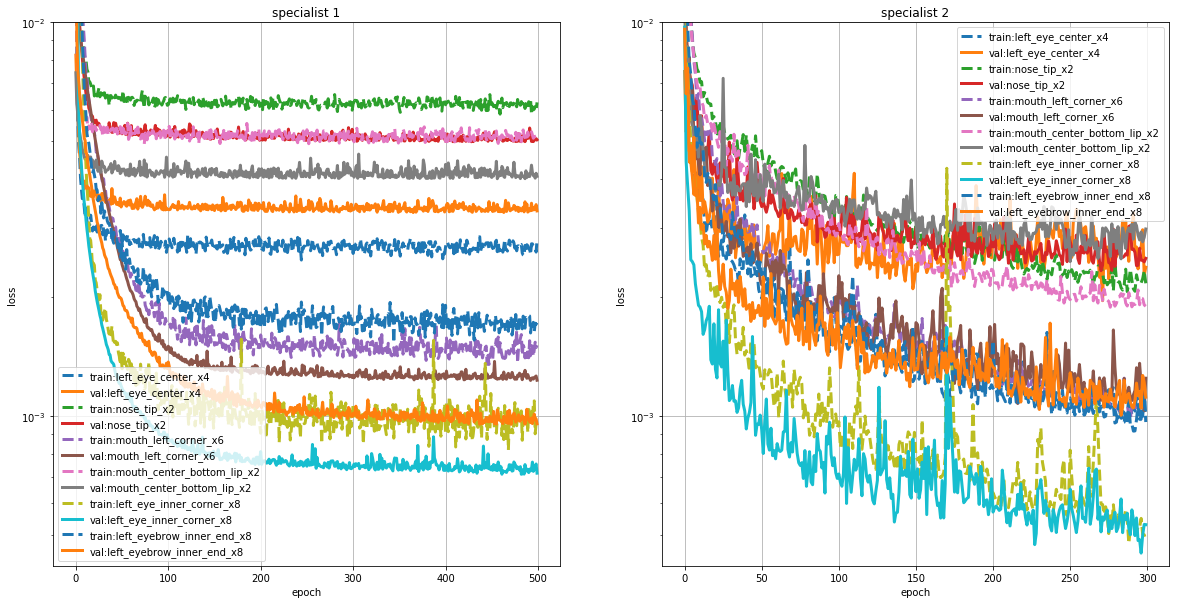

In [0]:
ylim = (7**(-4),10**(-2))
fig = plt.figure(figsize=(20,10))  

ax = fig.add_subplot(1,2,1)
ax.set_ylim(ylim)
ax.set_title("specialist 1")
plot_special_loss(specialists1,ax)

ax = fig.add_subplot(1,2,2)
ax.set_ylim(ylim)
ax.set_title("specialist 2")
plot_special_loss(specialists2,ax)

plt.show()



# ylim = (7**(-4),10**(-2))
# fig = plt.figure(figsize=(20,10))  

# ax = fig.add_subplot(1,2,1)
# ax.set_ylim(ylim)
# ax.set_title("specialist 1")
# plot_special_r2(specialists1,ax)

# ax = fig.add_subplot(1,2,2)
# ax.set_ylim(ylim)
# ax.set_title("specialist 2")
# plot_special_R2(specialists2,ax)

# plt.show()



In [0]:
df_y_pred_s2 = predict_specialist(specialists2,X_test)
prepare_submission(df_y_pred_s2,"special2")


(27124, 2)
File is saved at:special2.csv


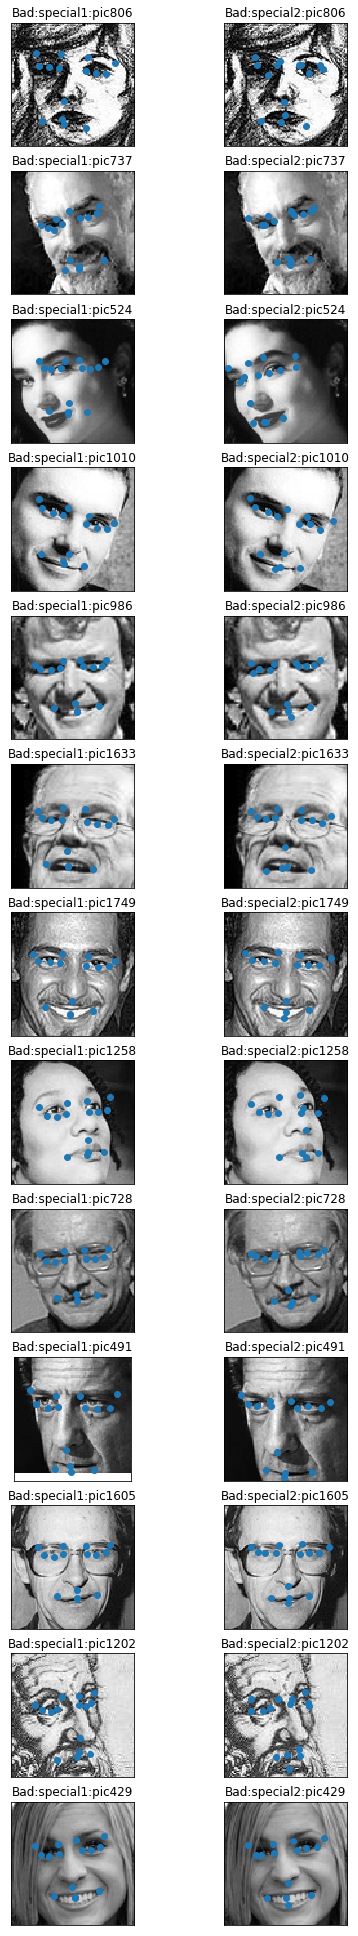

In [0]:
fig = plt.figure(figsize=(7,35))
y_pred_s2 = df_y_pred_s2.values
Nsample = 13
pic_index = df_compare["RowId"].iloc[:Nsample].values
pic_index_good = df_compare["RowId"].iloc[-Nsample:].values
count = 1


for ipic_g,ipic in zip(pic_index_good,pic_index):

    ax = fig.add_subplot(Nsample,2,count,xticks=[],yticks=[])
    count += 1
    plot_sample(X_test[ipic],y_pred_s[ipic],ax)
    ax.set_title("Bad:special1:pic"+str(ipic))
    
    ax = fig.add_subplot(Nsample,2,count,xticks=[],yticks=[])
    count += 1
    plot_sample(X_test[ipic],y_pred_s2[ipic],ax)
    ax.set_title("Bad:special2:pic"+str(ipic))
    
    

    
plt.show()